In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
import random
# pytorch > 5070 ti support on windows than tensorflow
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
print("cuda enabled: ", torch.cuda.is_available())

cuda enabled:  True


In [2]:
# following function will downscale photos
def bicubic_2x_downscale(hr_img_arr):
    height, width = hr_img_arr.shape[:2]
    
    new_width = width // 2
    new_height = height // 2
    
    lr_img_arr = cv2.resize(
        hr_img_arr, 
        (new_width, new_height), 
        interpolation=cv2.INTER_CUBIC
    )
    
    return lr_img_arr

In [3]:
hr_dir = os.path.join(".", "div2k_images", "hr")
train_paths = glob.glob(os.path.join(hr_dir, "train", "*.png"))
val_paths = glob.glob(os.path.join(hr_dir, "val", "*.png"))

train_y = []
train_x = []
for path in train_paths:
    img = Image.open(path)
    img_arr = np.array(img)
    # if odd resolution, strip last row or column
    # row
    if img_arr.shape[0] % 2 == 1:
        img_arr = img_arr[:-1, :, :] 
    # col
    if img_arr.shape[1] % 2 == 1:
        img_arr = img_arr[:, :-1, :]
    train_x.append(bicubic_2x_downscale(img_arr))
    train_y.append(img_arr)

val_y = []
val_x = []
for path in val_paths:
    img = Image.open(path)
    img_arr = np.array(img)
    # row
    if img_arr.shape[0] % 2 == 1:
        img_arr = img_arr[:-1, :, :] 
    # col
    if img_arr.shape[1] % 2 == 1:
        img_arr = img_arr[:, :-1, :]
    val_x.append(bicubic_2x_downscale(img_arr))
    val_y.append(img_arr)

In [4]:
print(train_x[1].shape)
print(train_y[1].shape)

(924, 1020, 3)
(1848, 2040, 3)


In [14]:
# break up images into randomly sampled x by x patches for the low res photos
# outputs tuple of high res patches and corresponding low res patches
def createPatches(hr: list, lr: list, patch_size: int, sample_per_image: int) -> tuple:
    if len(hr) != len(lr):
        raise ValueError("The HR and LR lists must contain the same number of images.")
    
    hr_patches = []
    lr_patches = []

    for hr_img, lr_img in zip(hr, lr):
        lr_h, lr_w = lr_img.shape[:2]

        if lr_h < patch_size or lr_w < patch_size:
            raise ValueError("The patch_size must not be larger than the width or height of any image in the LR list.")
        
        for _ in range(sample_per_image):
            # 1. Randomly sample top-left coordinate (x, y) from the Low Res image
            # limits are (width - patch_size) and (height - patch_size)
            lr_x = random.randint(0, lr_w - patch_size)
            lr_y = random.randint(0, lr_h - patch_size)
            
            # 2. Calculate the corresponding coordinates for the High Res image
            # Since HR is 2x LR, we multiply coordinates and size by 2
            hr_x = lr_x * 2
            hr_y = lr_y * 2
            hr_patch_size = patch_size * 2
            
            # 3. Crop the blocks
            # Slicing syntax: image[y : y + height, x : x + width]
            lr_patch = lr_img[lr_y : lr_y + patch_size, lr_x : lr_x + patch_size]
            hr_patch = hr_img[hr_y : hr_y + hr_patch_size, hr_x : hr_x + hr_patch_size]
            
            hr_patches.append(hr_patch)
            lr_patches.append(lr_patch)

    # Convert lists to numpy arrays
    return np.array(hr_patches), np.array(lr_patches)
        
train_y, train_x = createPatches(train_y, train_x, 32, 30)
val_y, val_x = createPatches(val_y, val_x, 32, 30)

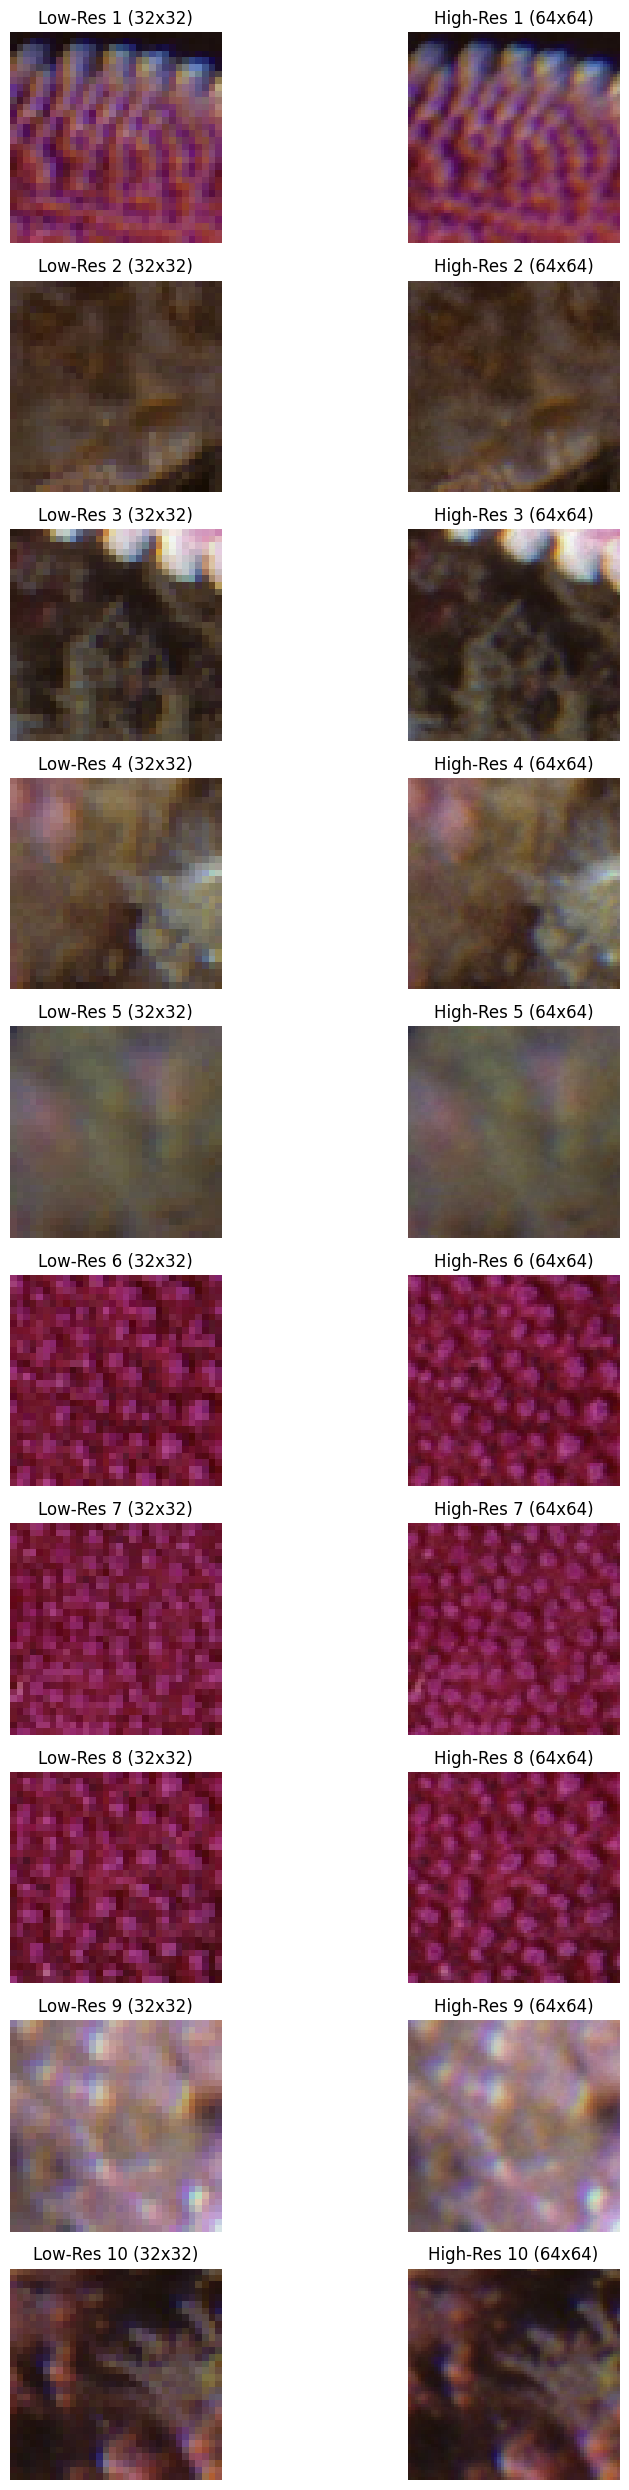

In [6]:
# Display first 10 images from train_y and train_x side by side
fig, axes = plt.subplots(10, 2, figsize=(10, 25))

for i in range(10):
    # Display low-res image (train_x) on the left
    axes[i, 0].imshow(train_x[i])
    axes[i, 0].set_title(f'Low-Res {i+1} ({train_x[i].shape[0]}x{train_x[i].shape[1]})')
    axes[i, 0].axis('off')
    
    # Display high-res image (train_y) on the right
    axes[i, 1].imshow(train_y[i])
    axes[i, 1].set_title(f'High-Res {i+1} ({train_y[i].shape[0]}x{train_y[i].shape[1]})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
print(train_x.shape)
print(train_y.shape)

(24000, 32, 32, 3)
(24000, 64, 64, 3)


In [22]:
class SuperResModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # Upsample bilinearly
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            # Conv: Learn features, keep size 64x64
            # PyTorch Conv2d Input: (Batch, Channels, Height, Width)
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),

            # Conv: Learn features, keep size 64x64
            # PyTorch Conv2d Input: (Batch, Channels, Height, Width)
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),

            # Conv: Learn features, keep size 64x64
            # PyTorch Conv2d Input: (Batch, Channels, Height, Width)
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),

            # Conv: Learn features, keep size 64x64
            # PyTorch Conv2d Input: (Batch, Channels, Height, Width)
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
class SuperResDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Grab a single item
        img_x = self.x_data[idx] # (32, 32, 3)
        img_y = self.y_data[idx] # (64, 64, 3)
        
        # Convert to Tensor
        tensor_x = torch.from_numpy(img_x).float()
        tensor_y = torch.from_numpy(img_y).float()
        
        # PERMUTE: Swap axes from (H, W, C) to (C, H, W)
        tensor_x = tensor_x.permute(2, 0, 1)
        tensor_y = tensor_y.permute(2, 0, 1)
        
        return tensor_x, tensor_y

In [24]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

dataset = SuperResDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)

model = SuperResModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using cuda device


In [26]:
# Training Loop
num_epochs = 5
print("Starting training...")

for epoch in range(num_epochs):
    model.train() # Set to training mode
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(dataloader):
        # Move data to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # 1. Zero Gradients
        optimizer.zero_grad()
        
        # 2. Forward Pass
        outputs = model(inputs)
        
        # 3. Compute Loss
        loss = criterion(outputs, targets)
        
        # 4. Backward Pass
        loss.backward()
        
        # 5. Optimize
        optimizer.step()
        
        # Logging
        running_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")

print("Done!")

Starting training...
Epoch [1/5], Step [0/22500], Loss: 137.3776
Epoch [1/5], Step [100/22500], Loss: 127.7406
Epoch [1/5], Step [200/22500], Loss: 120.7997
Epoch [1/5], Step [300/22500], Loss: 97.0188
Epoch [1/5], Step [400/22500], Loss: 126.2096
Epoch [1/5], Step [500/22500], Loss: 49.8408
Epoch [1/5], Step [600/22500], Loss: 68.4424
Epoch [1/5], Step [700/22500], Loss: 85.0733
Epoch [1/5], Step [800/22500], Loss: 101.4276
Epoch [1/5], Step [900/22500], Loss: 98.7904
Epoch [1/5], Step [1000/22500], Loss: 117.1760
Epoch [1/5], Step [1100/22500], Loss: 76.2103
Epoch [1/5], Step [1200/22500], Loss: 101.3917
Epoch [1/5], Step [1300/22500], Loss: 100.7817
Epoch [1/5], Step [1400/22500], Loss: 125.2522
Epoch [1/5], Step [1500/22500], Loss: 107.3782
Epoch [1/5], Step [1600/22500], Loss: 70.2110
Epoch [1/5], Step [1700/22500], Loss: 126.3183
Epoch [1/5], Step [1800/22500], Loss: 98.8486
Epoch [1/5], Step [1900/22500], Loss: 91.4779
Epoch [1/5], Step [2000/22500], Loss: 92.2491
Epoch [1/5], S

In [27]:
# testing:

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

test_dataset = SuperResDataset(val_x, val_y)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        
        # Inference
        preds = model(inputs)
        
        # Move to CPU to free GPU memory and store
        all_preds.append(preds.cpu())
        all_targets.append(targets) # targets are already CPU tensors from dataset

# 3. Concatenate all batches into single tensors
predicted_y = torch.cat(all_preds, dim=0)
actual_y = torch.cat(all_targets, dim=0)

# 4. Compute MSE
mse = torch.nn.functional.mse_loss(predicted_y, actual_y)

print(f"Predicted Y Shape: {predicted_y.shape}")
print(f"Final Test MSE: {mse.item()}")

Using cuda device
Predicted Y Shape: torch.Size([3000, 3, 64, 64])
Final Test MSE: 79.4588623046875


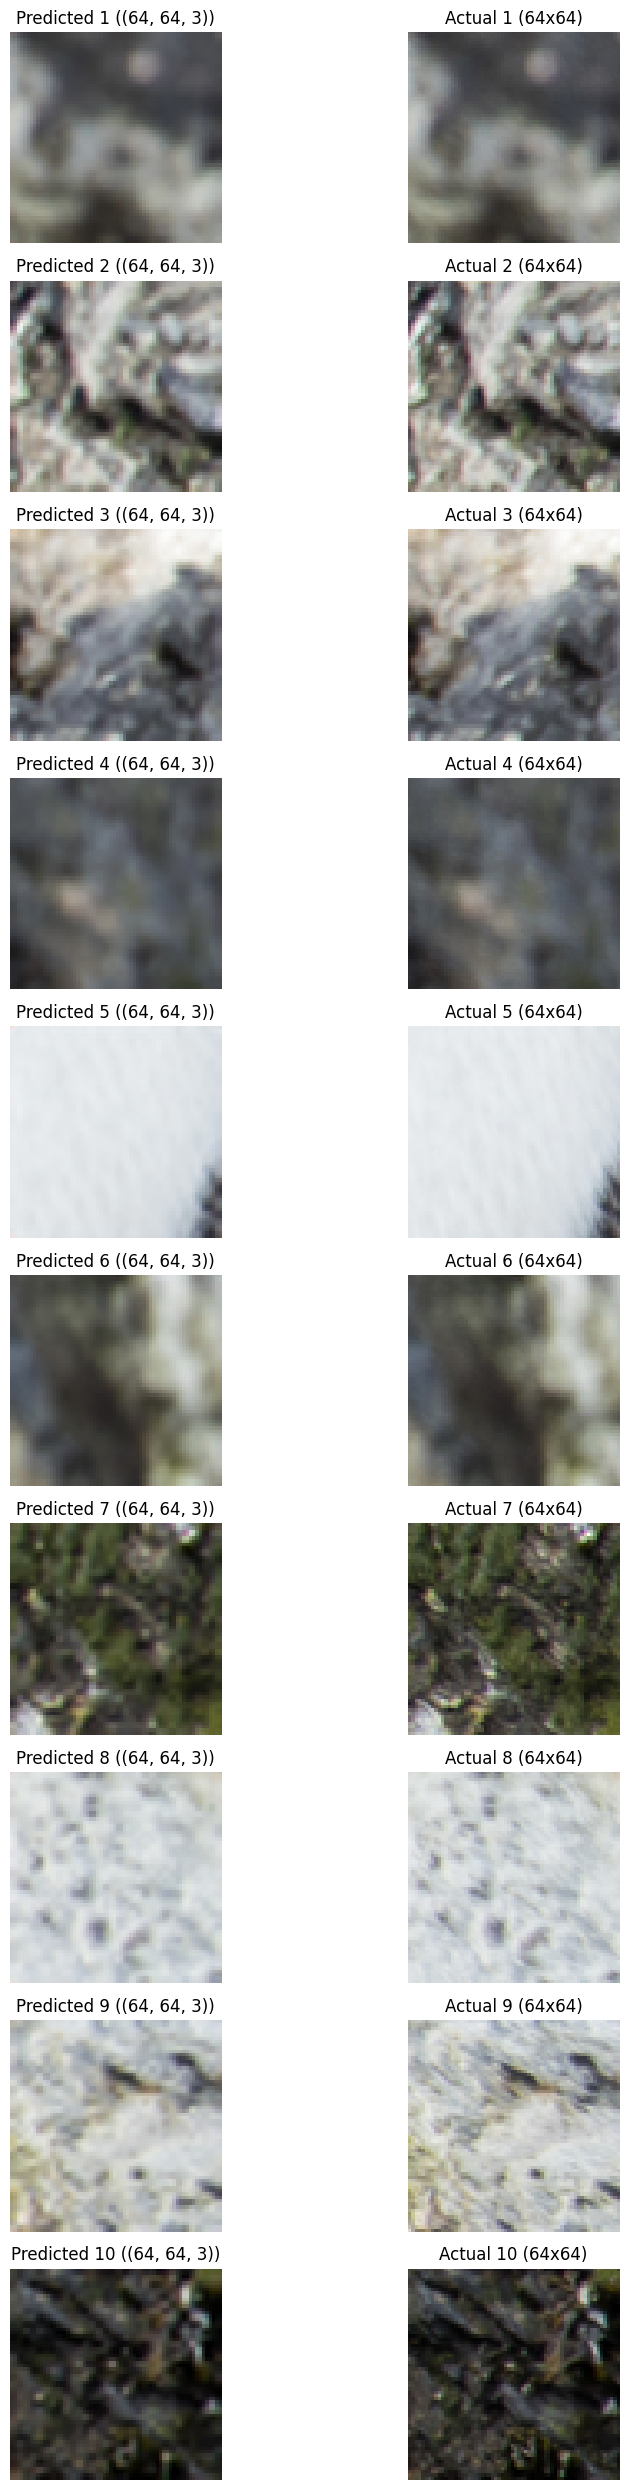

In [28]:
# visualize test output
# Display first 10 images from predicted_y and val_y side by side
fig, axes = plt.subplots(10, 2, figsize=(10, 25))

for i in range(10):
    # Display predicted image on the left
    pred_img = predicted_y[i].permute(1, 2, 0).numpy()
    pred_img = np.clip(pred_img, 0, 255).astype('uint8')
    axes[i, 0].imshow(pred_img)
    axes[i, 0].set_title(f'Predicted {i+1} ({pred_img.shape})')
    axes[i, 0].axis('off')
    
    # Display actual image on the right
    axes[i, 1].imshow(val_y[i])
    axes[i, 1].set_title(f'Actual {i+1} ({val_y[i].shape[0]}x{val_y[i].shape[1]})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()